### Importing Required libraries

In [4]:
import numpy as np
from numpy.random import seed, randint,randn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error,log_loss
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

seed(42)  # Reproducible Results with numpy

### LogisticRegression Class

In [11]:
class LogisticRegression:
    
    def __init__(self,fit_intercept=True, threshold = 0.5):
        self.fit_intercept = fit_intercept
        self.threshold = threshold
        self.w = None
        self.b = None

    
    def __weighted_sum(self,x):
        if self.fit_intercept:
            return np.dot(x,self.w.T)+self.b
        else:
            return np.dot(x,self.w.T)
    
    def __sigmoid(self,x):
        return 1.0/(1.0+np.exp(-(x)))
    
    
    def __grad_w_mse(self,x,y):
        yhat = self.__sigmoid(self.__weighted_sum(x))
        return ((yhat-y) * yhat * (1-yhat) * x)
    
    def __grad_b_mse(self,x,y):
        yhat = self.__sigmoid(self.__weighted_sum(x))
        return ((yhat-y) * yhat * (1-yhat))
    
    def __grad_w_cross_entropy(self,x,y):
        if (y == 0) or (y == 1):
            yhat = self.__sigmoid(self.__weighted_sum(x))
            return (yhat-y) * x
        else:
            raise ValueError('y should be 0 or 1')
    
    def __grad_b_cross_entropy(self,x,y):
        if (y == 0) or (y == 1):
            yhat = self.__sigmoid(self.__weighted_sum(x))
            return (yhat-y)
        else:
            raise ValueError('y should be 0 or 1')
    
    
    def train(self, X, Y, epochs=1, eta=0.1, loss_fn = 'cross_entropy', weights_init=True, verbose=0):
        # dict to persist loss per iteration
        loss_dt = {}
        
        if weights_init:
            self.w = np.random.randn(1,X.shape[1])
            if self.fit_intercept:
                self.b = 0
        
        for iteration in tqdm_notebook(range(epochs), total=epochs, unit='epoch'):
            dw = 0
            if self.fit_intercept:
                db = 0
            for x, y in zip(X,Y):
                if loss_fn == "mean_squared_error":
                    dw = dw + self.__grad_w_mse(x,y)
                    if self.fit_intercept:
                        db = db + self.__grad_b_mse(x,y)
                elif loss_fn == 'cross_entropy':
                    dw = dw + self.__grad_w_cross_entropy(x,y)
                    if self.fit_intercept:
                        db = db + self.__grad_b_cross_entropy(x,y)
            m = X.shape[0]
            self.w = self.w - eta * (dw/m)
            if self.fit_intercept:
                self.b = self.b - eta * (db/m)
            
            # compute the loss and put it in dict
            y_pred = self.__sigmoid(self.__weighted_sum(X))
            if loss_fn == "mean_squared_error":
                loss_dt[iteration] = mean_squared_error(y_pred,Y)
            elif loss_fn == "cross_entropy":
                loss_dt[iteration] = log_loss(Y,y_pred)
        
        if verbose:
            plt.plot(loss_dt.values())
            plt.xlabel('Epochs')
            if loss_fn == "mean_squared_error":
                plt.ylabel('Mean Squared Error')
            elif loss_fn == "cross_entropy":
                plt.ylabel('Log Loss')
            plt.show()
            
    def predict(self,X):
        y_pred = []
        for x in X:
            pred = self.__sigmoid(self.__weighted_sum(x))
            if float(pred) >= self.threshold:
                y_pred.append(1)
            else:
                y_pred.append(0)
        return np.array(y_pred)
    
    def predict_proba(self,X):
        y_pred = []
        for x in X:
            pred = self.__sigmoid(self.__weighted_sum(x))
            y_pred.append(pred)
        return np.array(y_pred)
    
                

### Train Model using Toy Data 

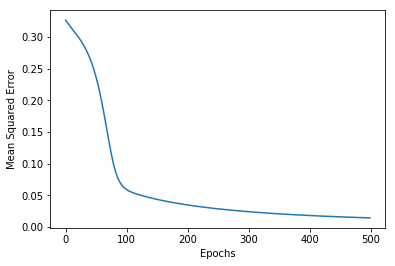

(array([[ 1.48488574, -0.48831183]]), array([-0.47468008]))

In [51]:
X = np.array([[2.5,2.5],[4,-1],[1,-4],[-3,1.25],[-2,-4],[1,5]])
Y = [1,1,1,0,0,0]
toy = LogisticRegression()
toy.train(X,Y,epochs=500,eta=0.1,loss_fn = 'mean_squared_error',verbose=1)
toy.w, toy.b

#### Predict on train 

In [52]:
y_pred = toy.predict(X)
y_pred

array([1, 1, 1, 0, 0, 0])

#### Calculate accuracy and f1score

In [53]:
print('Train Accuracy:{} and F1_Score:{}'
      .format(accuracy_score(Y,y_pred)*100, f1_score(Y,y_pred)))

Train Accuracy:100.0 and F1_Score:1.0


### Train the model using Iris dataset from sklearn

In [56]:
raw = load_iris()
data_x = raw['data']
data_y = raw['target']

# create the pandas dataframe
df = pd.DataFrame(data=data_x,columns=raw['feature_names'])

# concat the target to above dataframe
df['target'] = data_y

# It is multiclass problem , will convert it into binary
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

# separate features and target
X = df[['sepal length (cm)',  'sepal width (cm)', 'petal length (cm)','petal width (cm)']]
y = df['target']

# split into train test split
X_train_df,X_test_df,y_train_df,y_test_df = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

print('Shape of X_train_df:{} and y_train_df:{}'.format(X_train_df.shape,y_train_df.shape))
print('Shape of X_test_df:{} and y_test_df:{}'.format(X_test_df.shape,y_test_df.shape))

Shape of X_train_df:(120, 4) and y_train_df:(120,)
Shape of X_test_df:(30, 4) and y_test_df:(30,)


#### Check Distribution of target in train and test

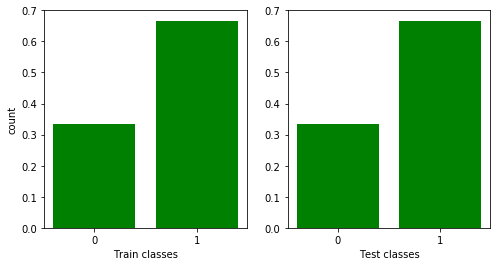

In [58]:
# check the distribution of target in train and test split
# fig, ax = plt.subplots(1,2)
fig, ax = plt.subplots(1,2,figsize=(8,4))

y1 = y_train_df.value_counts(normalize=True)
x1 = list(y_train_df.value_counts().index)
ax[0].bar(x1,y1,color='green')
ax[0].set_ylabel('count')
ax[0].set_xlabel('Train classes')
ax[0].set_xticks([0,1])

y2 = y_test_df.value_counts(normalize=True)
x2 = y_test_df.value_counts().index
ax[1].bar(x2,y2,color='green')
ax[1].set_xlabel('Test classes')
ax[1].set_xticks([0,1])

plt.show()

#### Train the model with loss_fn = 'mean_squared_error'

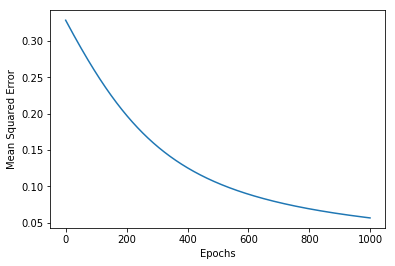

(array([[-0.76606098, -0.15487393,  1.32076574,  0.69360644]]),
 array([0.29706375]))

In [63]:
# Standadize the data
std = StandardScaler()
X_train = std.fit_transform(X_train_df)
X_test = std.transform(X_test_df)

# convert pandas dataframe to numpy array
y_train = y_train_df.values
y_test = y_test_df.values

# create an object of SigmoidNeuron
lr_mse = LogisticRegression()

# Train the model
lr_mse.train(X_train,y_train,epochs = 1000,eta=0.01, loss_fn = 'mean_squared_error',verbose=1)

# Print the weights and intercept
lr_mse.w, lr_mse.b

##### Get the predictions for train and test

In [64]:
y_pred_train = lr_mse.predict(X_train)
y_pred_test = lr_mse.predict(X_test)

##### Calculate accuracy and f1score

In [65]:
print('Train Accuracy:{} and F1_Score:{}'.format(accuracy_score(y_train,y_pred_train)*100, f1_score(y_train,y_pred_train)))
print('Test Accuracy:{} and F1_Score:{}'.format(accuracy_score(y_test,y_pred_test)*100, f1_score(y_test,y_pred_test)))

Train Accuracy:100.0 and F1_Score:1.0
Test Accuracy:100.0 and F1_Score:1.0


#### Train the model with loss_fn = 'cross_entropy'

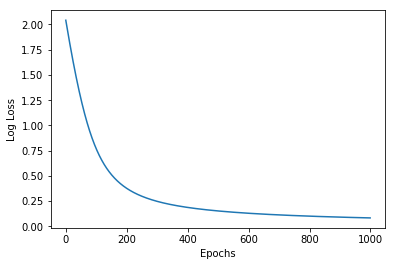

(array([[ 1.2311781 , -1.18908524,  0.31027696,  1.02721796]]),
 array([0.78667208]))

In [66]:
# Standadize the data
std = StandardScaler()
X_train = std.fit_transform(X_train_df)
X_test = std.transform(X_test_df)

# convert pandas dataframe to numpy array
y_train = y_train_df.values
y_test = y_test_df.values

# create an object of SigmoidNeuron
lr_ce = LogisticRegression()

# Train the model
lr_ce.train(X_train,y_train,epochs = 1000,eta=0.01, loss_fn = 'cross_entropy',verbose=1)

# Print the weights and intercept
lr_ce.w, lr_ce.b

##### Get the predictions for train and test

In [67]:
y_pred_train = lr_ce.predict(X_train)
y_pred_test = lr_ce.predict(X_test)

##### Calculate accuracy and f1score

In [68]:
print('Train Accuracy:{} and F1_Score:{}'.format(accuracy_score(y_train,y_pred_train)*100, f1_score(y_train,y_pred_train)))
print('Test Accuracy:{} and F1_Score:{}'.format(accuracy_score(y_test,y_pred_test)*100, f1_score(y_test,y_pred_test)))

Train Accuracy:100.0 and F1_Score:1.0
Test Accuracy:100.0 and F1_Score:1.0


### Train the model without intercept and using loss_fn = 'cross_entropy' on iris data

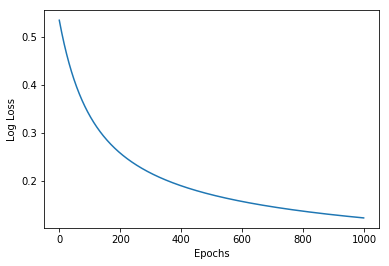

(array([[ 0.96659864, -1.1822059 ,  0.32664783,  1.52527828]]), None)

In [70]:
# Standadize the data
std = StandardScaler()
X_train = std.fit_transform(X_train_df)
X_test = std.transform(X_test_df)

# convert pandas dataframe to numpy array
y_train = y_train_df.values
y_test = y_test_df.values

# create an object of SigmoidNeuron
lr_ce_nob = LogisticRegression(fit_intercept=False)

# Train the model
lr_ce_nob.train(X_train,y_train,epochs = 1000,eta=0.01, loss_fn = 'cross_entropy',verbose=1)

# Print the weights and intercept
lr_ce_nob.w, lr_ce_nob.b

##### Get the predictions for train and test

In [71]:
y_pred_train = lr_ce_nob.predict(X_train)
y_pred_test = lr_ce_nob.predict(X_test)

##### Calculate accuracy and f1score

In [72]:
print('Train Accuracy:{} and F1_Score:{}'.format(accuracy_score(y_train,y_pred_train)*100, f1_score(y_train,y_pred_train)))
print('Test Accuracy:{} and F1_Score:{}'.format(accuracy_score(y_test,y_pred_test)*100, f1_score(y_test,y_pred_test)))

Train Accuracy:100.0 and F1_Score:1.0
Test Accuracy:100.0 and F1_Score:1.0
